# 尝试做一些简单的GPU/CPU在机器学习运算效率上的对比

In [ ]:
!pip install psutil  GPUtil

In [259]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
# 防止图形plt报错

In [261]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import numpy as np
import gc
import psutil
import GPUtil

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.layer1 = nn.Linear(20, 48);
        self.layer2 = nn.Linear(48,1);
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x) 
        #x = self.relu(x) # do wen need this?
        x
        return x


class cpugpu:
    def __init__(self, dataset_size=1000, device='cpu'):
        # 设置随机种子以确保结果可复现
        torch.manual_seed(42)
        
        self.device = device
        self.memory_usage = []
        self.gpu_memory_usage = []
        
        self.X = torch.rand(dataset_size, 20,device=device) # 4 featcure 100 rows Upper case X means traning dataset
        self.y = torch.ones(dataset_size, 1,device=device) * 5 # label data

        #y # y=f(x)+b 最终每一行的数据都要到5这里
        self.model = MyNet()
        self.model.to(device)
        
        self.loss_fn = nn.MSELoss()
        self.loss_fn.to(device)
        self.optimizier = optim.Adam(self.model.parameters(), lr=0.01) # 定义优化器和学习率
        #optimizier

        self.losses = []
        self.epoch_times = []
    
    def probeParam(self):
        total_params = sum(p.numel() for p in self.model.parameters())
        print(f"Total number of parameters: {total_params}")
        for name, param in self.model.named_parameters():
            print(f"Layer: {name} | Size: {param.size()} | Parameters: {param.numel()} | {param}")
        #grad
        for name, param in self.model.named_parameters():
            if param.grad is not None:
                print(f"  {name} gradient: {param.grad}")

    def train_in_epoch(self,epoch_index,num_epochs):
        start_time = time.time()  # 记录开始时间
        
        outputs = self.model(self.X)
        #print(outputs)
        #print(y.shape)
        loss = self.loss_fn(outputs , self.y) #计算结果和标注数据的 差 
        self.optimizier.zero_grad() 
        loss.backward()
        self.optimizier.step()
        
        # 记录损失
        self.losses.append(loss.item())
        end_time = time.time()  # 记录结束时间
        epoch_time = end_time - start_time
        self.epoch_times.append(epoch_time)

        # 记录内存使用情况
        self.memory_usage.append(psutil.virtual_memory().percent)
        if self.device == 'cuda':
            self.gpu_memory_usage.append(torch.cuda.memory_allocated() / torch.cuda.max_memory_allocated())
        
        # 打印每100个epoch的损失和时间
        if (epoch_index+1) % 500 == 0:
            print(f'Epoch [{epoch_index+1}/{num_epochs}], Loss: {loss.item():.4f}, Time: {epoch_time:.4f} seconds')
        
    
    def run_train(self,num_epochs=1000, show_time=1 ):
        # 训练模型
        self.losses = []
        self.epoch_times = []
        self.memory_usage = []
        self.gpu_memory_usage = []
        
        for epoch_index in range(num_epochs):
            self.train_in_epoch(epoch_index,num_epochs)
            #print(f"Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
            #print(f"Memory Cached: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")

        #if show_time == 1:
        #   self.showtime(num_epochs)
    def plot_memory_usage(self):
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, len(self.memory_usage)+1), self.memory_usage, label='CPU Memory')
        if self.device == 'cuda':
            plt.plot(range(1, len(self.gpu_memory_usage)+1), self.gpu_memory_usage, label='GPU Memory')
        plt.title('Memory Usage During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Memory Usage (%)')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def plot_loss_curve(self):
        gc.collect()  # 清理内存
        plt.figure(figsize=(12, 6))
        
        # 绘制损失曲线
        plt.plot(range(1, len(self.losses)+1), self.losses, label='Loss')
        
        # 找到最小损失值及其对应的 epoch
        min_loss = min(self.losses)
        min_epoch = self.losses.index(min_loss) + 1
        
        # 在图上标出最小损失点
        plt.scatter(min_epoch, min_loss, color='red', s=100, zorder=5)
        plt.annotate(f'Min Loss: {min_loss:.4f}\nEpoch: {min_epoch}', 
                     xy=(min_epoch, min_loss), xytext=(min_epoch+len(self.losses)/20, min_loss),
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="b", lw=2, alpha=0.8))
    
        plt.title('Training Loss Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        
        # 调整 y 轴的范围，使最小值点更明显
        plt.ylim(min_loss - (max(self.losses) - min_loss) * 0.1, 
                 max(self.losses[:int(len(self.losses) * 0.1)]))  # 只考虑前 10% 的损失值来设置上限
        
        plt.show()
        plt.close()  # 关闭图形以释放内存
    
    def test(self, test_size=100):
        # 生成测试数据
        X_test = torch.rand(test_size, 20, device=self.X.device)
        y_test = torch.ones(test_size, 1, device=self.X.device) * 5  # 使用与训练数据相同的目标值

        # 进行推理
        self.model.eval()  # 设置模型为评估模式
        with torch.no_grad():
            y_pred = self.model(X_test)

        # 将数据移到 CPU 并转换为 NumPy 数组以便绘图
        y_test = y_test.cpu().numpy()
        y_pred = y_pred.cpu().numpy()

        # 绘制比较图
        plt.figure(figsize=(12, 6))
        plt.scatter(range(test_size), y_test, color='blue', label='Actual', alpha=0.7)
        plt.scatter(range(test_size), y_pred, color='red', label='Predicted', alpha=0.7)
        plt.title('Actual vs Predicted Values')
        plt.xlabel('Sample Index')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

        # 计算并打印平均绝对误差
        mae = np.mean(np.abs(y_test - y_pred))
        print(f"Mean Absolute Error: {mae:.4f}")

        # 绘制误差分布图
        errors = y_test - y_pred
        plt.figure(figsize=(10, 5))
        plt.hist(errors, bins=50, edgecolor='black')
        plt.title('Error Distribution')
        plt.xlabel('Error')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

        return y_test, y_pred

In [263]:
#%matplotlib inline
test_suite = cpugpu()
test_suite.probeParam()


Total number of parameters: 1057
Layer: layer1.weight | Size: torch.Size([48, 20]) | Parameters: 960 | Parameter containing:
tensor([[ 0.0680, -0.1694, -0.1228, -0.1997, -0.1809, -0.1799, -0.0178, -0.0923,
         -0.2165,  0.1986,  0.0534, -0.1472, -0.1252, -0.0135,  0.1477, -0.0713,
         -0.0828,  0.1414, -0.0319, -0.0804],
        [ 0.1498, -0.1797,  0.0593, -0.1944,  0.0087, -0.0390, -0.1520, -0.1188,
          0.1438,  0.1775,  0.0467,  0.0938,  0.1257, -0.0386, -0.0123,  0.1817,
          0.1371, -0.0848,  0.0510,  0.0679],
        [-0.0791,  0.1362, -0.0889,  0.0916,  0.1261, -0.0226, -0.1766, -0.1842,
         -0.0282,  0.1246,  0.2012,  0.1336,  0.0138, -0.0242,  0.0249, -0.0800,
         -0.0453,  0.1265, -0.1825, -0.1414],
        [-0.0596, -0.1395, -0.1668,  0.1099,  0.1007,  0.1186, -0.1578,  0.0688,
          0.1192,  0.0453, -0.1049, -0.1001,  0.1226,  0.0740,  0.0574, -0.1708,
         -0.1994,  0.1751,  0.0139,  0.1887],
        [-0.2144, -0.1047, -0.2070,  0.2068

## 使用CPU 10000 epoch 1000数据集 CPU times: total: 12.6 s Wall time: 13.3 s

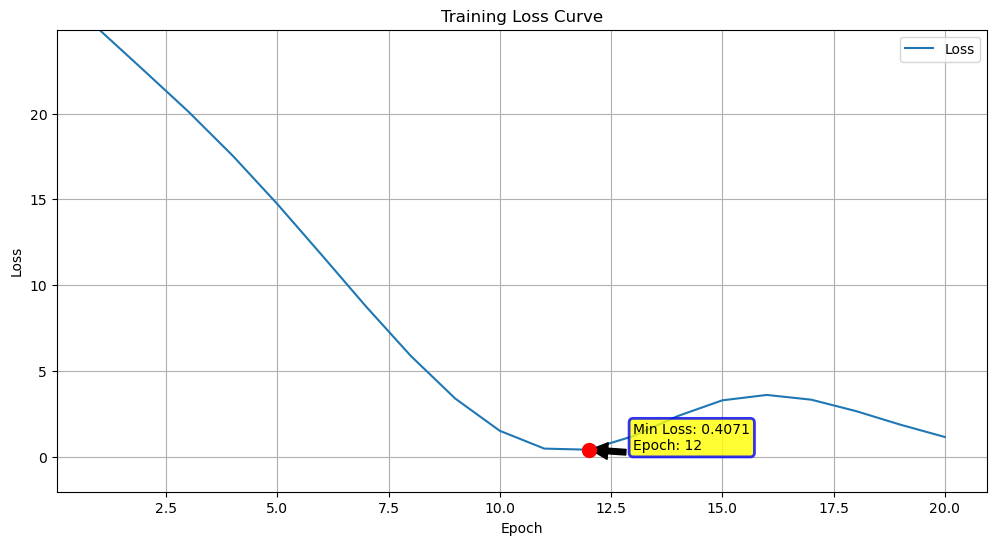

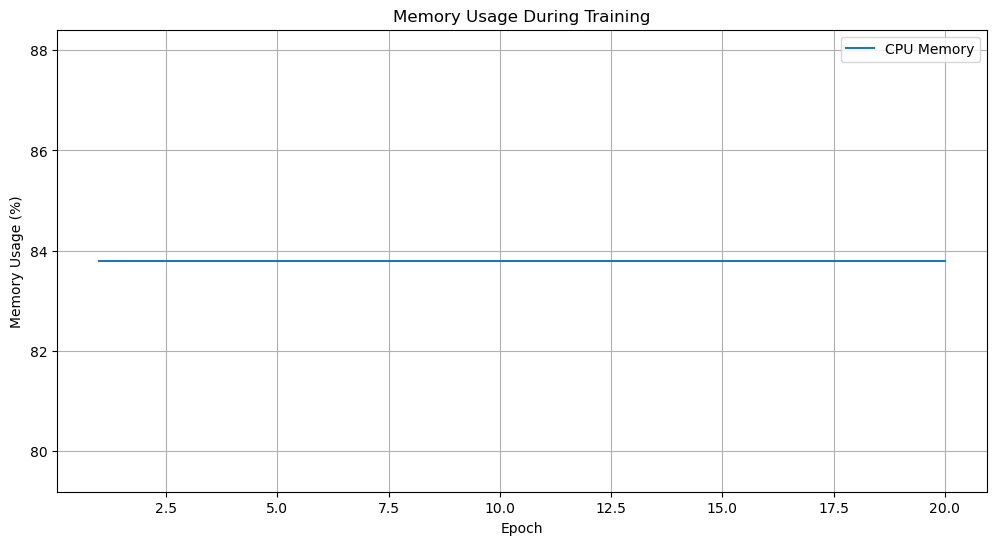

CPU times: total: 969 ms
Wall time: 1.58 s


In [275]:
%%time
%matplotlib inline
x = cpugpu()
x.run_train(20)
x.plot_loss_curve()
x.plot_memory_usage()


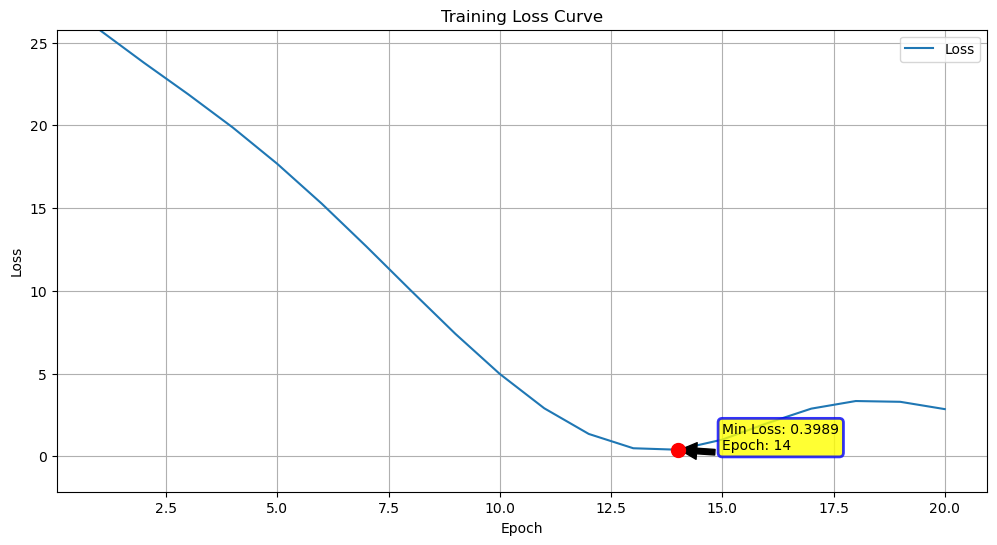

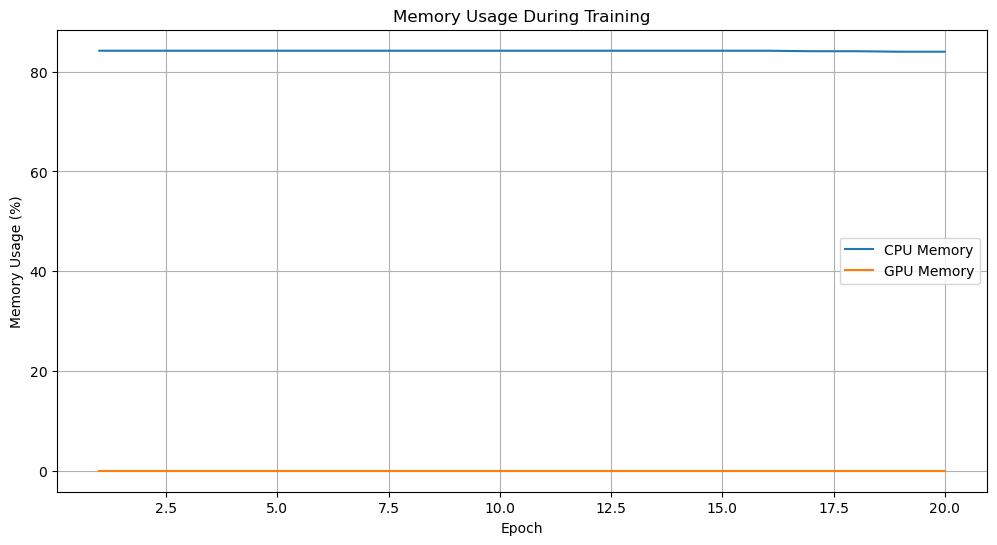

CPU times: total: 766 ms
Wall time: 793 ms


In [277]:
%%time
%matplotlib inline
x = cpugpu(device='cuda')
x.run_train(20)
x.plot_loss_curve()
x.plot_memory_usage()


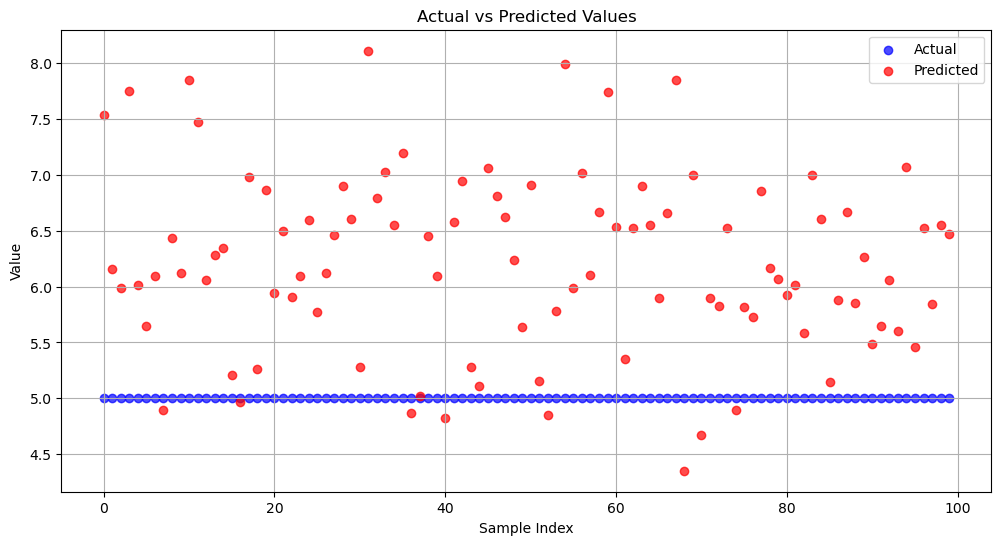

Mean Absolute Error: 1.2459


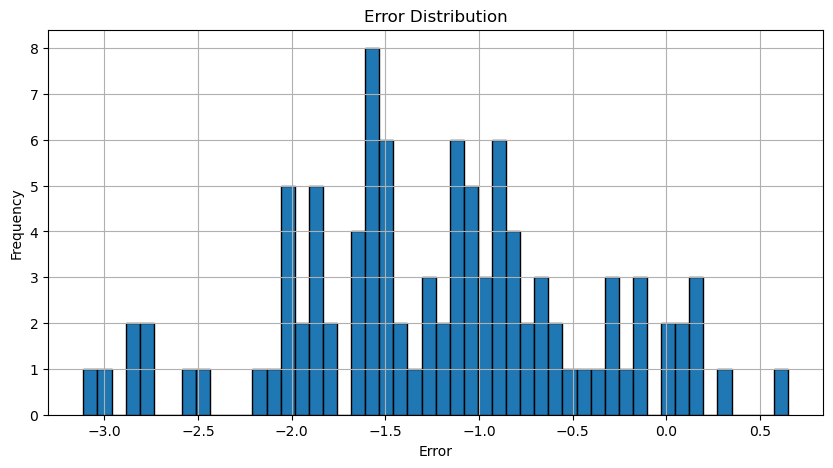

CPU times: total: 562 ms
Wall time: 579 ms


(array([[5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
      

In [279]:
%%time
%matplotlib inline
x.test()

## 使用GPU 10000 epoch 1000数据集 CPU times: total: 12.6 s Wall time: 13.3 s

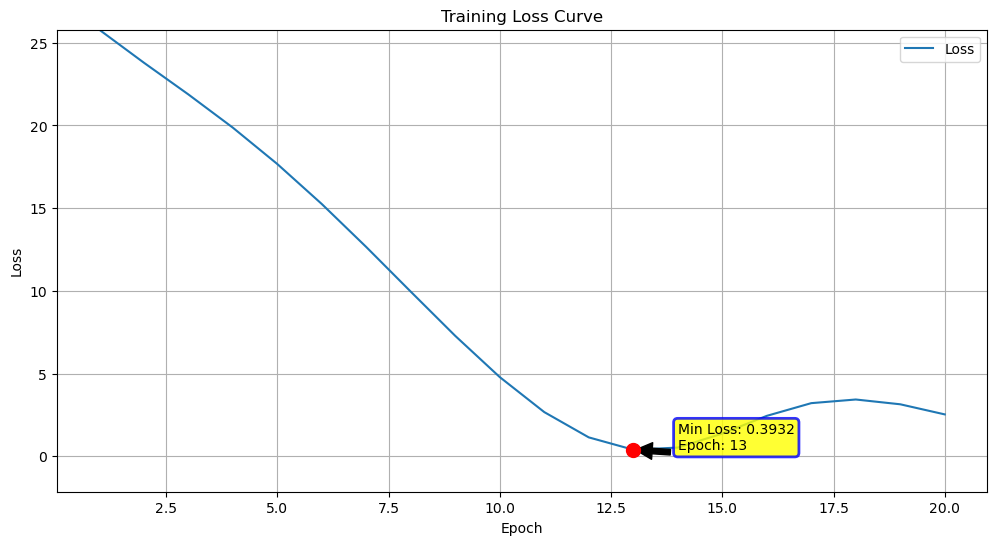

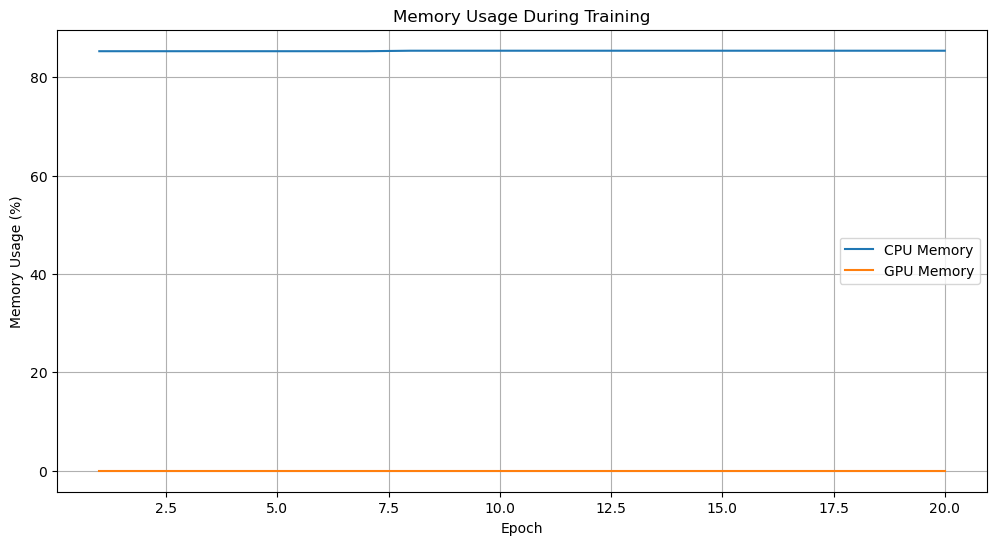

CPU times: total: 797 ms
Wall time: 794 ms


In [271]:
%%time
x = cpugpu(device='cuda',dataset_size=200000)
x.run_train(20)
x.plot_loss_curve()
x.plot_memory_usage()

## 下面会尝试比较在相同数据集大小和epoch情况 GPU的能力将帮助您更好地理解 CUDA 和 CPU 在不同规模任务上的性能差异。

GPU runtime: 1.41 秒
CPU tuntime: 21.95 秒


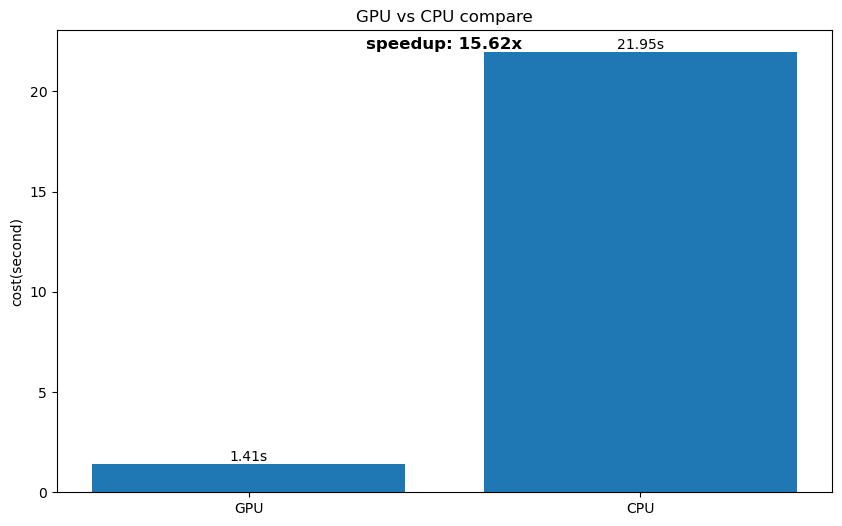


GPU 时间: 1.41 秒
CPU 时间: 21.95 秒
GPU 相对于 CPU 的加速比: 15.62x


In [177]:
%matplotlib inline

def run_and_time(device, dataset_size, epochs):
    start_time = time.time()
    x = cpugpu(device=device, dataset_size=dataset_size)
    x.run_train(epochs)
    end_time = time.time()
    return end_time - start_time

test_epoch = 100
test_data_size=1000000
# 运行 GPU 版本
gpu_time = run_and_time('cuda', test_data_size, test_epoch)
print(f"GPU runtime: {gpu_time:.2f} 秒")

# 运行 CPU 版本
cpu_time = run_and_time('cpu', test_data_size, test_epoch)
print(f"CPU tuntime: {cpu_time:.2f} 秒")

# 创建柱状图比较 GPU 和 CPU 的运行时间
plt.figure(figsize=(10, 6))
plt.bar(['GPU', 'CPU'], [gpu_time, cpu_time])
plt.title('GPU vs CPU compare')
plt.ylabel('cost(second)')
plt.text('GPU', gpu_time, f'{gpu_time:.2f}s', ha='center', va='bottom')
plt.text('CPU', cpu_time, f'{cpu_time:.2f}s', ha='center', va='bottom')

# 计算加速比
speedup = cpu_time / gpu_time
plt.text(0.5, max(gpu_time, cpu_time), f'speedup: {speedup:.2f}x', 
         ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

# 打印详细比较
print(f"\nGPU 时间: {gpu_time:.2f} 秒")
print(f"CPU 时间: {cpu_time:.2f} 秒")
print(f"GPU 相对于 CPU 的加速比: {speedup:.2f}x")

# 探索对GPU现存和内存的占比

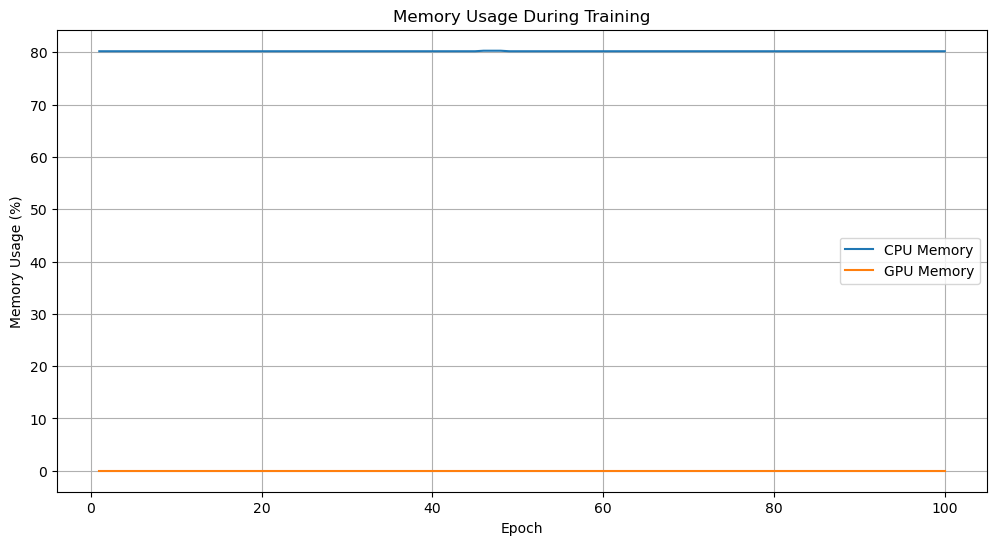

CPU times: total: 422 ms
Wall time: 421 ms


In [246]:
%%time
x = cpugpu(device='cuda',dataset_size=10000)
x.run_train(100)
x.plot_memory_usage()